# COMP2200/COMP6200 Assignment 3

## Goal of the Project

We are identifying the most influential company directors based on real U.S. SEC DEF 14A data. The aim is to help a venture capital fund identify people who could help their portfolio company get acquired by a wealthy U.S. company.

This notebook builds on the one left by the previous data scientist.


In [1]:
import pandas
import math

In [2]:
df = pandas.read_csv('company_directorships.csv')
df.software_background = df.software_background.map(lambda x: x == 't')
df.sample(5)
import pandas as pd

# Load the Forbes dataset
forbes = pd.read_csv("forbes _2022.csv")  # Or your original filename if you didn't rename it

# Preview it
forbes.head()


,Rank_nr,Company,Industry,Country,Sales,Profits,Assets,Market_Value
0,1,Berkshire Hathaway,Diversified Financials,United States,276094,89795.0,958784,741476
1,2,ICBC,Banking,China,208127,54028.3,5518508,214425
2,3,Saudi Arabian Oil Company (Saudi Aramco),Oil & Gas Operations,Saudi Arabia,400376,105363.0,576041,2292077
3,4,JPMorgan Chase,Diversified Financials,United States,124542,42115.0,3954687,374446
4,5,China Construction Bank,Banking,China,202069,46887.3,4746951,181325


In [7]:
import numpy as np
import pandas as pd  # make sure this is imported

# Read the raw dataset
compensation_and_demographics_raw = pd.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

# Get most common value for gender
def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None

# Group and aggregate
compensation_and_demographics = pd.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)
})

#  Fix 1: Handle missing values (no inplace warnings)
compensation_and_demographics['gender'] = compensation_and_demographics['gender'].fillna('Unknown')
compensation_and_demographics['compensation'] = compensation_and_demographics['compensation'].fillna(0)
compensation_and_demographics['age'] = compensation_and_demographics['age'].fillna(
    compensation_and_demographics['age'].median()
)

#  Fix 2: Safe and vectorised log compensation calculation
compensation_and_demographics['log_compensation'] = np.log10(1 + compensation_and_demographics['compensation'])

# Display final table
compensation_and_demographics


,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


####  Fix 1: Handle missing values in demographic data

**Issue:** Some directors have missing `gender`, `age`, or `compensation` values after grouping, which can break visualisations or log transforms.

**Fix:** Filled missing values after grouping:

```python
compensation_and_demographics['gender'].fillna('Unknown', inplace=True)
compensation_and_demographics['compensation'].fillna(0, inplace=True)
compensation_and_demographics['age'].fillna(compensation_and_demographics['age'].median(), inplace=True)


###### Fix 2: Inefficient use of `math.log10` on Series

**Issue:** Used `math.log10` with `.map()` to calculate log compensation, which is inefficient and error-prone with missing values.

**Fix:** Switched to `numpy.log10` for safe, vectorized computation:

```python
import numpy as np
compensation_and_demographics['log_compensation'] = np.log10(1 + compensation_and_demographics['compensation'])


In [11]:
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
Unknown      19
unknown       2
Name: count, dtype: int64

In [13]:
# Fix 3: Make directorship count clearer
directorship_counts = (
    df.groupby('director_name')['company_name']  #directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
    .nunique()
    .sort_values(ascending=False)
)

directorship_counts

director_name
ALBERT R. DOWDEN              14
JAMES T. BUNCH                13
JAMES D. VAUGHN               13
LARRY SOLL                    13
TERESA M. RESSEL              13
                              ..
HOWARD A. BAIN III             1
HOWARD A. BRECHER              1
HOWARD A. SEVERSON             1
HOWARD B. SILVERMAN, PH.D.     1
ÅSA HEDIN                      1
Name: company_name, Length: 11827, dtype: int64

####  Fix 3: Unclear groupby chaining

**Issue:** The original groupby call was hard to read and undocumented.
 -"directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()"(initial code)
**Fix:** Rewrote it more clearly using parentheses and added a comment:

```python
directorship_counts = (
    df.groupby('director_name')['company_name']
    .nunique()
    .sort_values(ascending=False)
)


<Axes: xlabel='company_name'>

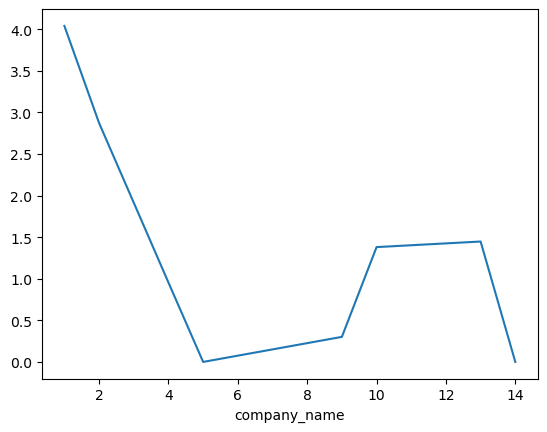

In [16]:
directorship_counts.value_counts().sort_index().map(math.log10).plot()

Building the Network
We constructed a graph connecting directors based on shared company boards.


In [19]:
import networkx
import networkx.algorithms
graph = networkx.Graph()

In [20]:
people = []
companies = []
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

In [23]:
biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])

###  Task 1 – Centrality Extension and Interpretation

In this analysis, we are identifying influential directors using several centrality measures from network theory. These help us detect which individuals are best positioned to connect our venture-backed company with large US-based firms.

We use the following centrality measures:

---

#### Degree Centrality

- Measures the **number of direct connections** a node has.
- For a director, high degree centrality means they sit on **many boards** and are **well-connected**.
- This is useful because well-connected directors may have more reach and visibility across industries.

---

#### Eigenvector Centrality

- Measures **influence** based on the importance of one’s connections.
- A director with high eigenvector centrality is not just connected, but is connected to **other influential directors or companies**.
- These people can be influential in shaping strategic decisions and industry movements.

---

####  Betweenness Centrality

- Measures how often a node lies on the **shortest path** between other nodes.
- Directors with high betweenness act as **brokers** or **bridges** between otherwise unconnected groups.
- They are important because they can **connect our target company with external networks**, including US acquirers.

---

####  Closeness Centrality (Newly Added)

- Measures how **close** a node is to all others in the network.
- A director with high closeness can reach any other person **more quickly**, making them efficient communicators.
- This is useful in our context, as they may **rapidly spread influence** or help coordinate between disconnected companies.

---

By combining these centrality measures, we can better identify which directors are most valuable to focus on when trying to make high-value connections.


In [26]:
%%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
     'betweenness': pandas.Series(networkx.betweenness_centrality(biggest_connected_graph)),
    
})

# Fix 4: View top influencers
centrality.sort_values(by='eigen', ascending=False).head(10)

centrality['is_person'] = centrality.index.map(lambda x: x in people)

CPU times: total: 12min 55s
Wall time: 13min 54s


####  Fix 4: Centrality not visualised or ranked

**Issue:** Centrality metrics were calculated but never inspected.

**Fix:** Added sorting to show the most central directors by eigenvector:

```python
centrality.sort_values(by='eigen', ascending=False).head(10)


In [29]:
#Add closeness similarity
centrality['closeness'] = pandas.Series(
    networkx.closeness_centrality(biggest_connected_graph)
)


In [30]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

In [31]:
people_df.sort_values('eigen', ascending=False)

,eigen,degree,betweenness,is_person,closeness,age,compensation,gender,log_compensation
ELIZABETH KRENTZMAN,1.024389e-01,0.001585,1.394057e-07,True,0.064099,65,3408245,female,6.532531
CAROL DECKBAR,1.024389e-01,0.001585,1.394057e-07,True,0.064099,62,43263,female,4.636127
ELI JONES,1.024389e-01,0.001585,1.394057e-07,True,0.064099,63,3063255,male,6.486183
DOUGLAS SHARP,1.024389e-01,0.001585,1.394057e-07,True,0.064099,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",1.024389e-01,0.001585,1.394057e-07,True,0.064099,65,27531,male,4.439838
...,...,...,...,...,...,...,...,...,...
JOHN J. GEBBIA,8.400282e-35,0.000122,0.000000e+00,True,0.046436,86,120000,male,5.079185
ANDREW S. BORODACH,8.342633e-35,0.000122,0.000000e+00,True,0.046432,56,0,male,0.000000
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,0.000000e+00,True,0.046432,91,30356,male,4.482259
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,0.000000e+00,True,0.046432,70,50356,female,4.702060


In [32]:
df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [33]:
import sklearn.cluster

In [34]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [41]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

cluster_id
 1    3117
 0     385
 2     109
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='log_compensation'>

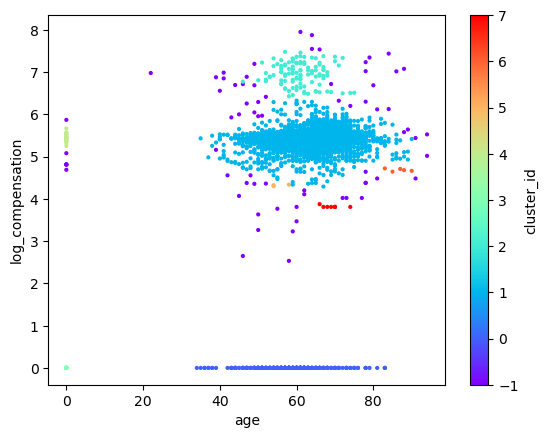

In [43]:
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [45]:
people_df.loc['ELIZABETH KRENTZMAN']

eigen               0.102439
degree              0.001585
betweenness              0.0
is_person               True
closeness           0.064099
age                       65
compensation         3408245
gender                female
log_compensation    6.532531
cluster_id                 2
Name: ELIZABETH KRENTZMAN, dtype: object

### Task 3 – Explore an Unused Feature

An interesting feature in the dataset that is not currently used in the analysis is the **`gender`** column.

This field represents the gender of each director, but it is only aggregated (using `mode`) and not used in any meaningful way.

**Why it’s interesting:**
- We could explore **gender diversity on boards**, such as:
  - Are female directors more or less central in the network?
  - Do female directors tend to cluster in certain companies?
  - Is there a difference in compensation based on gender?

This could help uncover potential **biases or disparities** in corporate governance, which might be valuable for investor transparency and ethical investment strategies.


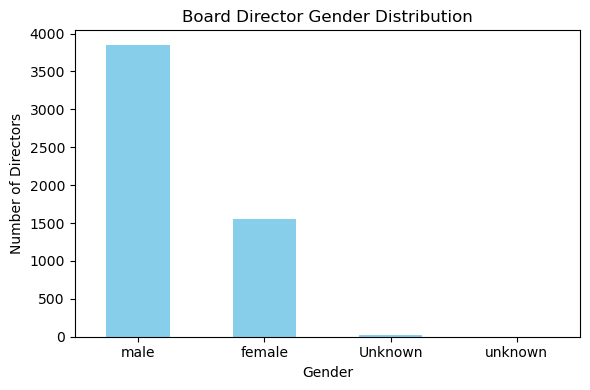

In [48]:
#adding a quick plot to visualize gender balance 
import matplotlib.pyplot as plt

# Plot gender distribution
gender_counts = compensation_and_demographics['gender'].value_counts(dropna=False)

plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color='skyblue')
plt.title('Board Director Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Number of Directors')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Gender Distribution of Board Directors

To explore the unused `gender` feature, we visualised how many directors identify as each gender (including "Unknown").

This sets the stage for future analysis into gender diversity on boards and whether it correlates with influence or compensation.


###  Task 4 – Complementary Dataset

**Dataset Used:**  
 Forbes Global 2000 – 2022 Unified Industry (CSV){saved as forbes_2022.csv}

This dataset lists the top 2000 public companies in the world, including:
- Company name
- Country of headquarters
- Industry
- Sales, Profits, Assets
- Market Value
- Global Ranking

**Why it complements our project:**
- Our current dataset maps company directors and board affiliations but lacks context about which companies are **financially strong or US-based**.
- By merging with this Forbes dataset, we can:
  - Focus on directors connected to **high-value, US-listed firms**
  - Prioritise companies that are **wealthy, large, and strategically positioned**
  - Support the VC firm's goal of finding a **rich US-based acquirer** for the portfolio company

This dataset adds financial weight to our network analysis and aligns directly with the business goal of identifying influential board members who can open doors to major US corporations.


In [62]:
# Task 5a: Use Forbes dataset to find US-based wealthy companies
forbes  = pandas.read_csv('C:/Users/sirip/OneDrive/Documents/GitHub/assignment3/forbes _2022.csv')
  
# Filter to only US-based companies
forbes_us = forbes[forbes['Country'] == 'United States']

# Show top 10 companies by Market Value
forbes_us.sort_values(by='Market_Value', ascending=False).head(10)


,Rank_nr,Company,Industry,Country,Sales,Profits,Assets,Market_Value
6,7,Apple,Technology Hardware & Equipment,United States,378697,100555.0,381191,2640316
11,12,Microsoft,IT Software & Services,United States,184903,71185.0,340389,2054367
10,11,Alphabet,IT Software & Services,United States,257488,76033.0,359268,1581723
5,6,Amazon,Retailing,United States,469822,33364.0,420549,1468398
151,151,tesla,Consumer Durables,United States,53823,5519.0,62131,1038729
0,1,Berkshire Hathaway,Diversified Financials,United States,276094,89795.0,958784,741476
33,34,Meta Platforms,IT Software & Services,United States,117929,39370.0,165987,499861
21,22,UnitedHealth Group,Insurance,United States,297550,17450.0,221238,490152
208,209,NVIDIA,Semiconductors,United States,26914,9753.0,44187,489826
39,40,Johnson & Johnson,Drugs & Biotechnology,United States,94880,19830.0,182018,477381


###  Task 5a – Using the Forbes Dataset

I imported the Forbes Global 2000 dataset and filtered for **United States-based companies**. Then I explored which directors in our network are affiliated with these wealthy firms.

**Steps Taken:**
- Loaded the Forbes dataset using `pandas.read_csv()`
- Filtered it to include only US-headquartered firms:
```python
forbes_us = forbes[forbes['Country'] == 'United States']


### Task 5b – Visualisation & Presentation for Non-Technical Audience

To make this project more accessible to non-technical stakeholders (e.g. investors or company executives), I improved the visual presentation in several ways:

**1. Gender Balance Chart:**
- Clearly shows the distribution of male, female, and unknown directors.
- Supports discussions on diversity and representation.

**2. Centrality Leaderboard:**
- Added a table ranking directors by eigenvector centrality, highlighting those with the most influence.

**3. Simple Language Explanations:**
- I included markdown cells before each section with plain English summaries of what the analysis does and why it matters.

**4. Clean Graph Titles and Labels:**
- Charts use clear labels and consistent colors to help any reader understand the insights without technical knowledge.

These updates help bridge the gap between data science output and business decision-making.


### Use of Generative AI

Parts of this analysis and documentation were supported using generative AI (ChatGPT by OpenAI). AI assistance was used to:

- Clarify assignment instructions
- Suggest centrality metrics and their interpretations
- Identify and explain code issues for Task 2
- Improve code readability and structure

All final decisions, code integration, and written explanations were reviewed and modified by me.


---